In [ ]:
from google.colab import files

uploaded = files.upload()

Saving iswc.json to iswc.json


In [ ]:
import json

with open('iswc.json', 'r') as file:
     iswc = json.load(file)

## JSON input conversion
### From:
[{"year": year,
  "tkg": link,
  "metrics": [{"metric": metric_name,
               "concepts": [{uri: value},
                            (...)]},
              (...)]},
 (...)]
 
 ### To:
{metric_name: {uri: {year: value,
                     (...)},
               (...)},
 (...)}

In [ ]:
all_concepts = set()
all_metrics = set()
all_years = set()

data = dict()

for entry in iswc:
    year = entry['year']
    all_years.add(year)
    for metrics in entry['metrics']:
        metric_name = metrics['metric']
        all_metrics.add(metric_name)
        metric_concepts = metrics['concepts']
        for concept in metric_concepts:
            for key, value in concept.items():
                all_concepts.add(key)
                #print("{} : {} : {} : {} ".format(metric_name, year, key, value))
                curr = {key: {year: value}}
                if metric_name in data.keys():
                    if key in data[metric_name].keys():
                        data[metric_name][key].update(curr[key])
                    else:
                        data[metric_name].update(curr)
                else:
                    data[metric_name] = curr

print('# of concepts: {}'.format(len(all_concepts)))
print('# of metrics: {}'.format(len(all_metrics)))
print('# of editions: {} ({} to {})'.format(len(all_years),\
                                            min(all_years), max(all_years)))

# of concepts: 958
# of metrics: 12
# of editions: 19 (2002 to 2020)


### Method to create a dataframe for a metric's annual data

In [ ]:
import pandas as pd

def create_df(metric="pagerank", verbose=True):
    df = pd.DataFrame(data[metric]).sort_index(ascending=True)
    if verbose:
        print(f'Annual data for {metric}')
        display(df)
    return df

### Method to print the heatmap of a data frame

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

def plot_df_heatmap(df, title="", dpi=100, num_lines=200):
    df_t = df.transpose()
    df_heat = df_t.iloc[df_t.isnull().sum(axis=1).mul(1).argsort()].head(num_lines)
    plt.figure(figsize=(80, 60), dpi=dpi)
    ax = sns.heatmap(df_heat, linewidth=0.5, square=True, cmap='coolwarm')
    plt.title(title)
    plt.show()

## Print a metric's annual data and plot its heatmap

Annual data for pagerank


,http://local/local.owl#semantic_web,http://local/local.owl#semantics,http://local/local.owl#ontologies,http://local/local.owl#ontology,http://local/local.owl#rdf_data,http://local/local.owl#rdf,http://local/local.owl#content_providers,http://local/local.owl#semantic_web_technologies,http://local/local.owl#software_agents,http://local/local.owl#software,http://local/local.owl#web_mining,http://local/local.owl#process_model,http://local/local.owl#knowledge_sharing,http://local/local.owl#world_wide_web,http://local/local.owl#process_models,http://local/local.owl#ontology_languages,http://local/local.owl#semantic_web_applications,http://local/local.owl#xml,http://local/local.owl#description_logics,http://local/local.owl#artificial_intelligence,http://local/local.owl#knowledge_representation,http://local/local.owl#semantic,http://local/local.owl#haskell,http://local/local.owl#network_analysis,http://local/local.owl#information_retrieval,http://local/local.owl#intelligent_software_agents,http://local/local.owl#description_logic,http://local/local.owl#automation,http://local/local.owl#web_services_descriptions,http://local/local.owl#web_resources,http://local/local.owl#web_information,http://local/local.owl#ontology_development,http://local/local.owl#ontology_engineering,http://local/local.owl#communication,http://local/local.owl#logic_programming,http://local/local.owl#rdf_graphs,http://local/local.owl#application_layer,http://local/local.owl#consistency_checking,http://local/local.owl#classification_approach,http://local/local.owl#engineering,...,http://local/local.owl#interpretability,http://local/local.owl#sat_solver,http://local/local.owl#multihop,http://local/local.owl#heterogeneous_databases,http://local/local.owl#type_safety,http://local/local.owl#complex_question,http://local/local.owl#multicriteria_decision_making,http://local/local.owl#graphbased_representation,http://local/local.owl#peertopeer_systems,http://local/local.owl#truthful_mechanisms,http://local/local.owl#computing_systems,http://local/local.owl#random_walk_algorithm,http://local/local.owl#syntactic__information,http://local/local.owl#relational_learning,http://local/local.owl#statistic,http://local/local.owl#raster_data,http://local/local.owl#text_categorization,http://local/local.owl#data_protection,http://local/local.owl#interpreter,http://local/local.owl#query_optimizer,http://local/local.owl#steiner_tree,http://local/local.owl#random_walks,http://local/local.owl#web_graph,http://local/local.owl#search_behaviors,http://local/local.owl#gaussian_distributions,http://local/local.owl#classification_models,http://local/local.owl#classification_approaches,http://local/local.owl#combinatorial_optimization_problem,http://local/local.owl#classification_model,http://local/local.owl#collaborative_filtering,http://local/local.owl#syntactic_structure,http://local/local.owl#similar_cases,http://local/local.owl#search_session,http://local/local.owl#efficient_computation,http://local/local.owl#boosting,http://local/local.owl#cold_start_problem,http://local/local.owl#cold_start,http://local/local.owl#online_learning,http://local/local.owl#supervised_classifiers,http://local/local.owl#interleaves
2002,0.001862,0.001270,0.001133,0.001088,0.000609,0.000481,0.000473,0.000462,0.000411,0.000362,0.000351,0.000346,0.000332,0.000332,0.000328,0.000313,0.000310,0.000305,0.000304,0.000297,0.000295,0.000295,0.000293,0.000289,0.000286,0.000285,0.000283,0.000281,0.000281,0.000278,0.000277,0.000270,0.000267,0.000265,0.000261,0.000259,0.000258,0.000254,0.000243,0.000240,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003,0.000851,0.001054,NaN,0.001320,0.000121,0.000472,NaN,0.000124,0.000189,0.000138,NaN,0.000294,NaN,0.000271,NaN,0.000314,NaN,0.000170,0.000188,NaN,NaN,0.000251,NaN,NaN,0.000222,NaN,0.000118,0.000143,NaN,0.000259,NaN,0.000232,NaN,0.000139,NaN,0.000164,NaN,NaN,N

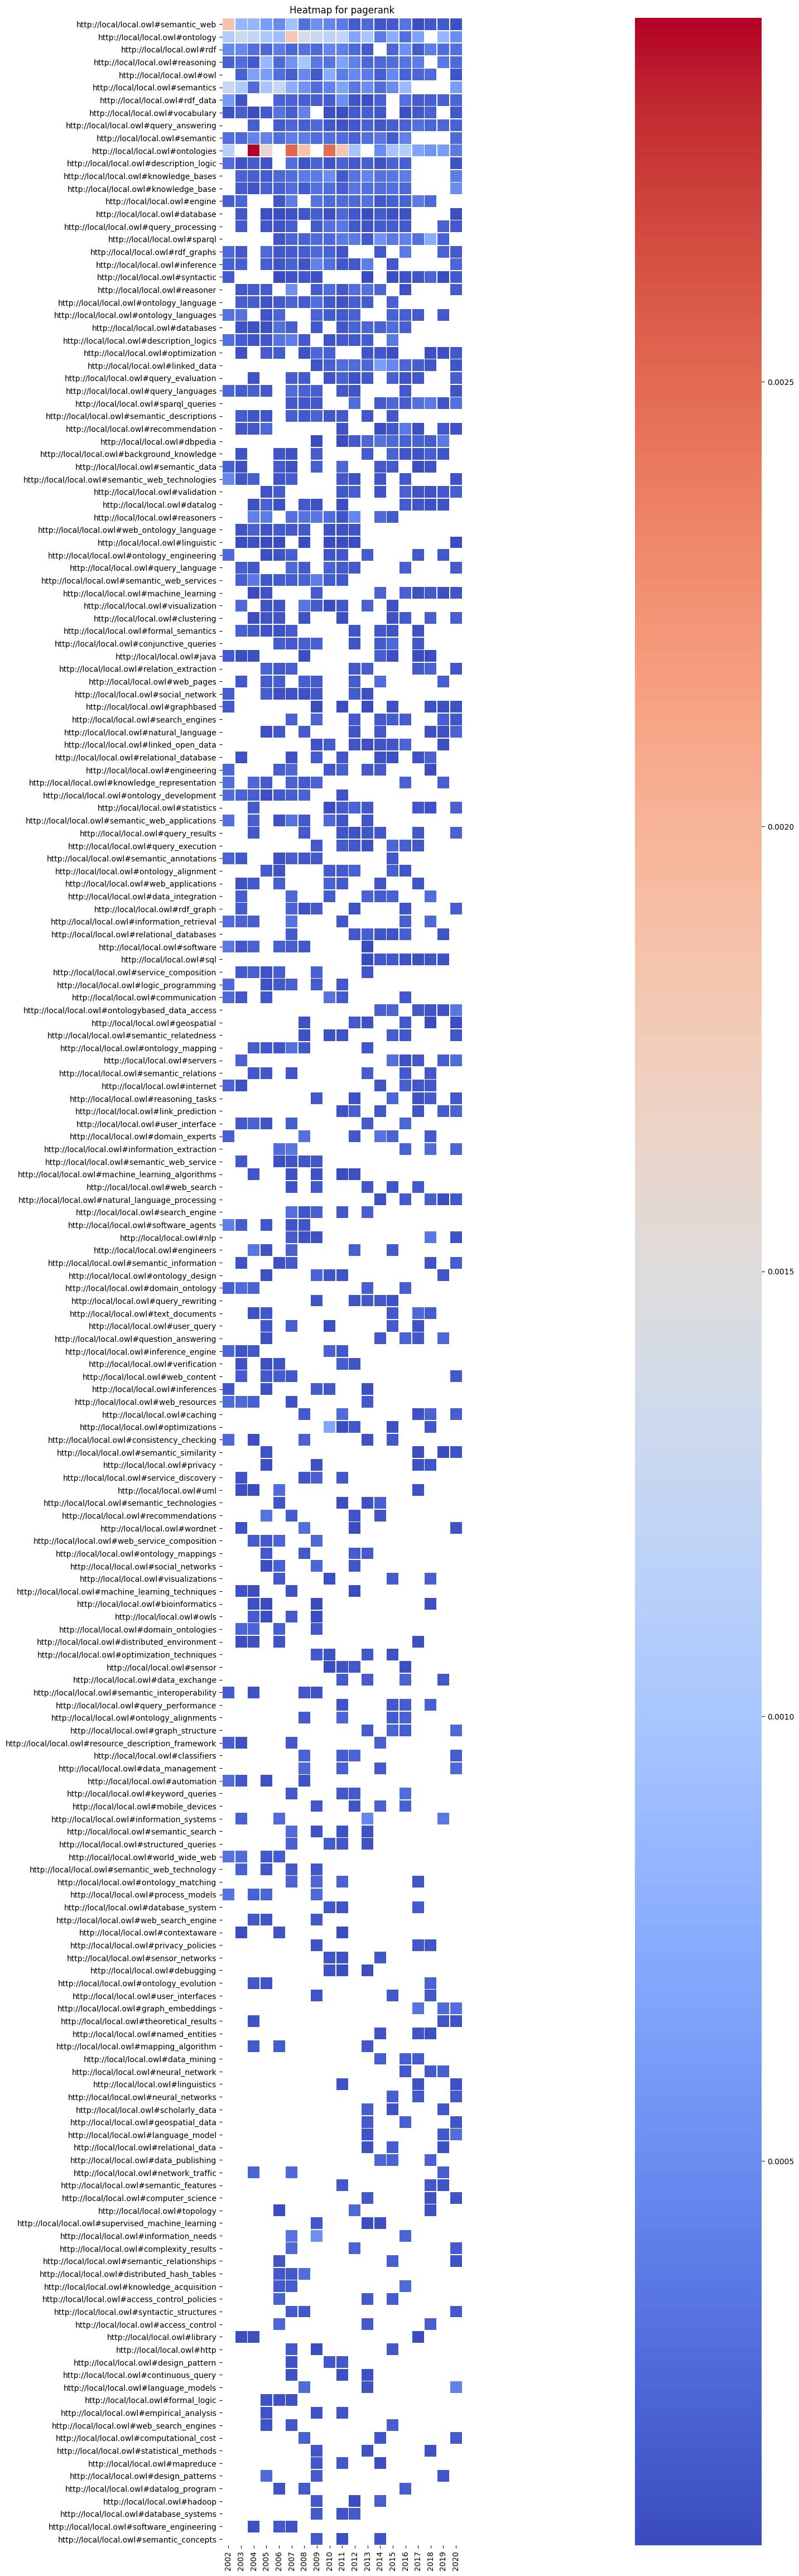

In [ ]:
metric_of_interest = "pagerank"

df = create_df(metric=metric_of_interest)

plot_df_heatmap(df, title=f'Heatmap for {metric_of_interest}')

### Method to plot a series

In [ ]:
def plot_series(df, x, y, breakpoints=[], title="", xlabel='Year', ylabel='Value', dpi=100, type='line'):
    plt.figure(figsize=(12,5), dpi=dpi)
    if type == 'bar':
        plt.bar(x, y)
    else:
        plt.plot(x, y, 'o-')
        plt.grid()
    for i in breakpoints:
        plt.axvline(i, color='red', linestyle='dashed')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

## Print a series that describes a given concept evolution over the years, considering a specific metric

In [ ]:
concept_of_interest = 'http://local/local.owl#ontology'

concept_series = df[concept_of_interest]
concept_series

2002    0.001088
2003    0.001320
2004    0.001211
2005    0.001031
2006    0.000914
2007    0.001819
2008    0.001413
2009    0.001280
2010    0.001181
2011    0.001240
2012    0.000696
2013    0.001016
2014    0.000370
2015    0.000762
2016    0.000290
2017    0.000677
2018         NaN
2019    0.000855
2020    0.000511
Name: http://local/local.owl#ontology, dtype: float64

In [ ]:
concept_series.describe()

count    18.000000
mean      0.000982
std       0.000390
min       0.000290
25%       0.000713
50%       0.001023
75%       0.001233
max       0.001819
Name: http://local/local.owl#ontology, dtype: float64

## Method to determine the trend of a Series

In [ ]:
import numpy as np

def trendline(data, order=1):
    if len(set(data)) == 1: # constant data
       return 0

    coeffs = np.polyfit(data.index.values.astype(int), list(data.fillna(0)), order)
    slope = coeffs[-2]
    return float(slope)

series_slope = trendline(concept_series)
if series_slope > 0:
    print("Increasing trend")
elif series_slope < 0:
    print("Decreasing trend")
else:
    print("Neutral trend")

Decreasing trend


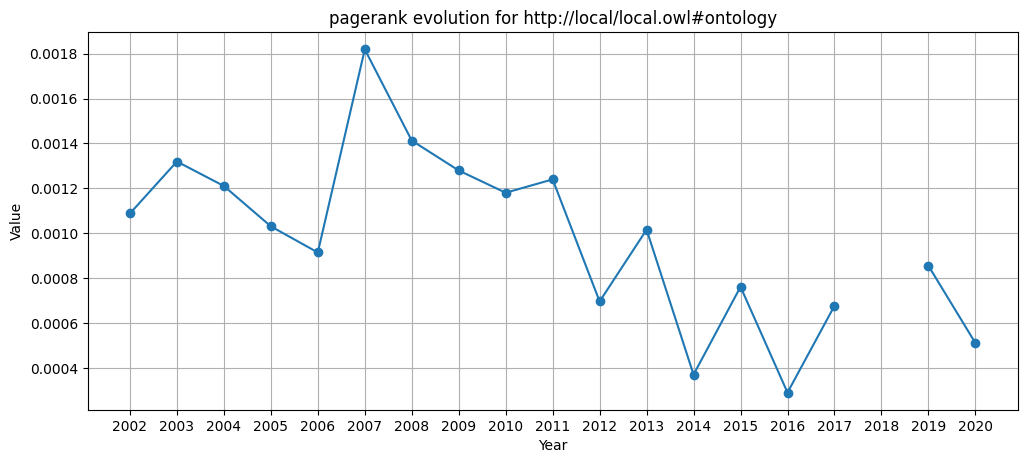

Max. value on 2007: 0.001819195125771072
Min. value on 2016: 0.0002903939236953841


In [ ]:
plot_series(concept_series, x=concept_series.index, y=concept_series.values,\
        title='{} evolution for {}'.format(metric_of_interest, concept_of_interest))

print(f'Max. value on {concept_series.idxmax()}: {concept_series.loc[concept_series.idxmax()]}')
print(f'Min. value on {concept_series.idxmin()}: {concept_series.loc[concept_series.idxmin()]}')

## Use the Fisher-Jenks algorithm to detect breakpoints in a series 

In [ ]:
pip install jenkspy

     |████████████████████████████████| 55 kB 2.7 MB/s 
  Created wheel for jenkspy: filename=jenkspy-0.2.0-cp37-cp37m-linux_x86_64.whl size=70410 sha256=9987b6d39be6a26a1511107cdde4575bd61a9a5436bb6e9a7cbe0817a60c8772
  Stored in directory: /root/.cache/pip/wheels/d8/d1/42/9bd05164ef706b84674905892f0542f8db6ac4a652473ca7e0
Successfully built jenkspy


In [ ]:
from jenkspy import JenksNaturalBreaks

def get_breakpoints(series):
    jnb = JenksNaturalBreaks()
    jnb.fit(np.array(series.fillna(0)))

    breaks = []
    for v in jnb.inner_breaks_:
        if v == 0: # NaN case
            continue
        idx = series.index.values[series == v][0]
        breaks.append(idx)
    return breaks

breaks = get_breakpoints(concept_series)
breaks

['2016', '2020', '2019', '2002', '2008']

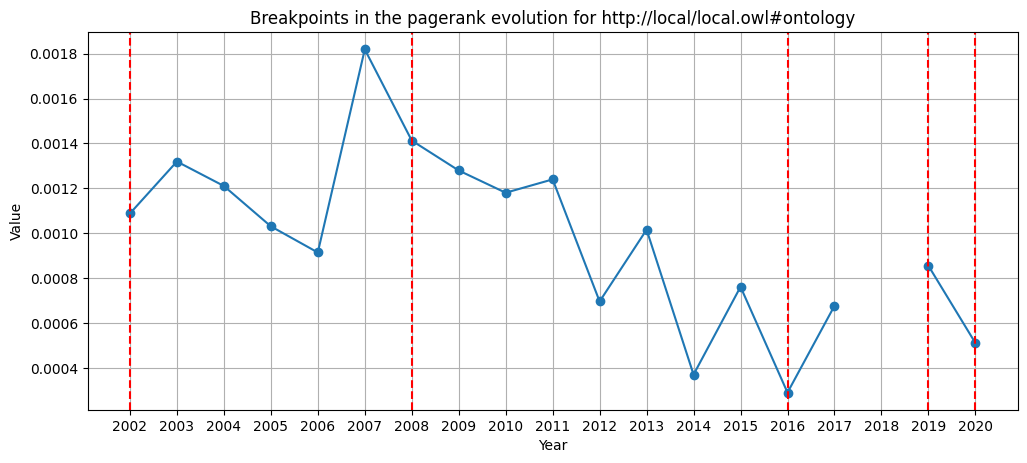

In [ ]:
plot_series(concept_series, breakpoints=breaks, x=concept_series.index, y=concept_series.values,\
        title='Breakpoints in the {} evolution for {}'.format(metric_of_interest, concept_of_interest))

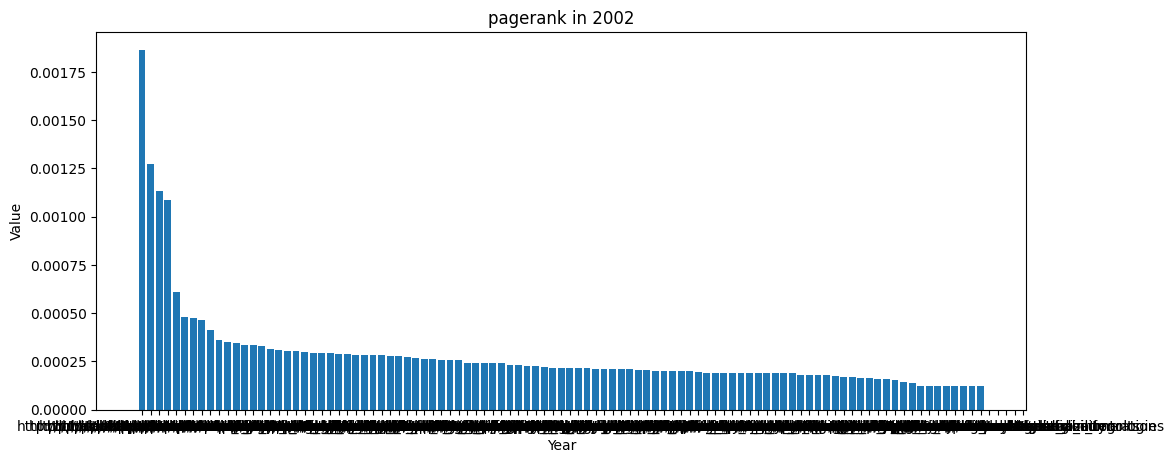

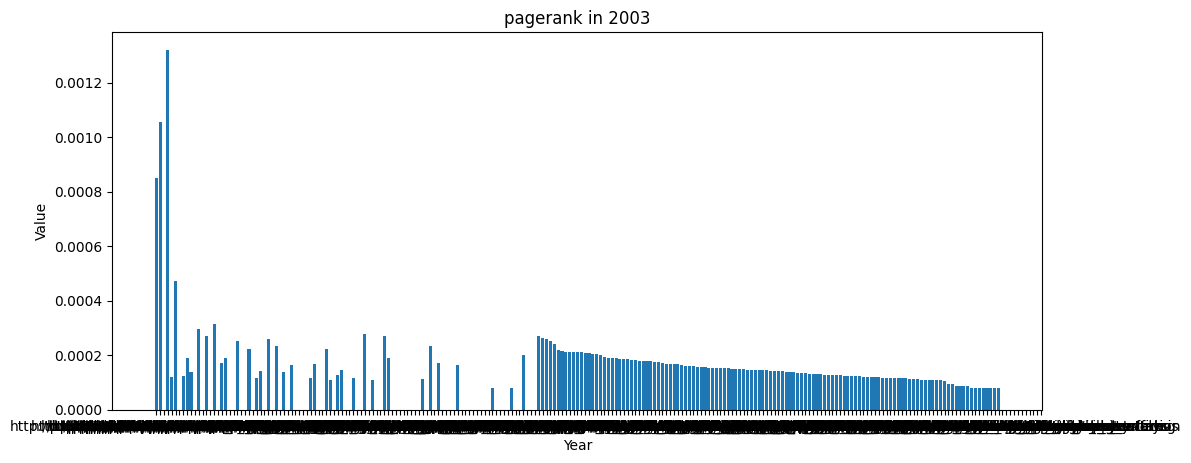

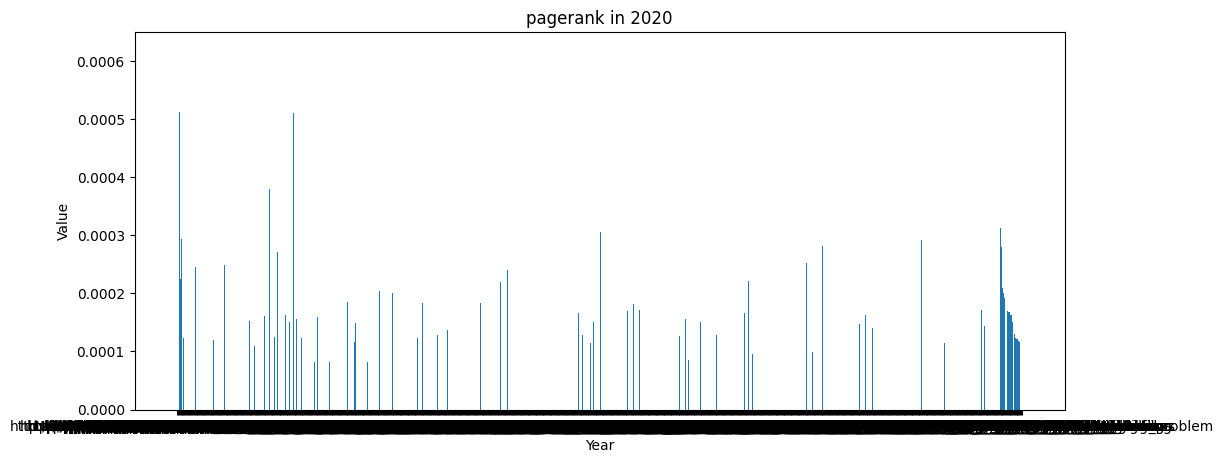

In [ ]:
for y in [2002, 2003, 2020]:
    plot_series(df.loc[f'{y}'], x=df.loc[f'{y}'].index, y=df.loc[f'{y}'].values, type='bar', title=f'{metric_of_interest} in {y}')